# **INTRODUCTION**  

In this notebook, the previously trained model is applied,  
primarily using the RL4CO library.

# **CONFIG AND INSTALL**

In [ ]:
%%capture
#!pip install -U git+https://github.com/ai4co/rl4co.git
!pip install wandb --upgrade
!pip install pandas
!pip install numpy

!pip install rl4co[graph] # include torch-geometric

!pip install git+https://github.com/ai4co/rl4co.git

!pip install vrplib

In [ ]:
%%capture
%load_ext autoreload
%autoreload 2

import os
import re
import vrplib

import pandas as pd
import numpy as np

from rl4co.envs.routing.mtvrp.env import MTVRPEnv # MTVRP -> Multi-Task VRP
from rl4co.envs.routing.mtvrp.generator import MTVRPGenerator
from rl4co.utils.trainer import RL4COTrainer
from rl4co.models.zoo import MVMoE_POMO
from rl4co.models.zoo.am import AttentionModel
from rl4co.utils.ops import gather_by_index

import torch
from lightning.pytorch.callbacks import ModelCheckpoint, RichModelSummary

from einops import repeat

from google.colab import drive

import wandb
from lightning.pytorch.loggers import WandbLogger

from rl4co.envs import TSPEnv, CVRPEnv
from rl4co.models.zoo.am import AttentionModel
from rl4co.utils.trainer import RL4COTrainer
from rl4co.utils.decoding import get_log_likelihood
from rl4co.models.zoo import EAS, EASLay, EASEmb, ActiveSearch

from tqdm import tqdm
from math import ceil

## Mount

In [ ]:
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Colab Notebooks')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Mounted at /content/drive


# **DOWNLOAD MODEL**



In [ ]:
#corresponde à experiência 20
model_name = "epoch_epoch=009.ckpt"
model_folder = "exp20_final_ovrpb_144pts_MVMoE_POMO_8BS_10epocas"

checkpoint_path = f"./lightning_logs/{model_folder}/checkpoints/{model_name}"

# The same class used during training must be used.
lit_model = MVMoE_POMO.load_from_checkpoint(checkpoint_path, load_baseline=False)

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'env' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['env'])`.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'policy' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['policy'])`.


In [ ]:
print(lit_model)

MVMoE_POMO(
  (env): MTVRPEnv()
  (policy): AttentionModelPolicy(
    (encoder): AttentionModelEncoder(
      (init_embedding): MTVRPInitEmbedding(
        (init_embed): Linear(in_features=7, out_features=128, bias=True)
        (init_embed_depot): Linear(in_features=2, out_features=128, bias=True)
      )
      (net): GraphAttentionNetwork(
        (layers): Sequential(
          (0): MultiHeadAttentionLayer(
            (0): SkipConnection(
              (module): MultiHeadAttention(
                (Wqkv): Linear(in_features=128, out_features=384, bias=True)
                (out_proj): Linear(in_features=128, out_features=128, bias=True)
              )
            )
            (1): Normalization(
              (normalizer): InstanceNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
            )
            (2): SkipConnection(
              (module): MoE(
                (experts): ModuleList(
                  (0-3): 4 x MLP(
                    (hidden

In [ ]:
print(lit_model.policy.encoder.init_embedding.init_embed,'\n')
for name, param in lit_model.policy.encoder.init_embedding.init_embed.named_parameters():
    print(name, param,'\n')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Linear(in_features=7, out_features=128, bias=True) 

weight Parameter containing:
tensor([[ 5.7639e-02,  3.5357e-01,  3.4209e-01, -2.4554e-01, -2.6023e-01,
         -1.3175e-01,  2.7425e-01],
        [ 3.2484e-02,  2.9254e-01, -1.9779e-01,  2.9126e-01,  8.2297e-02,
         -3.2190e-01,  1.7562e-01],
        [-3.1864e-01,  1.9962e-01,  9.1444e-02, -3.1370e-01,  1.0340e-02,
         -3.4069e-01,  3.3621e-01],
        [ 4.3961e-02, -2.7880e-01, -2.9781e-02, -3.4441e-01, -2.2850e-01,
          1.1209e-01,  1.1890e-01],
        [ 3.1586e-01, -7.1762e-02, -3.4500e-01, -4.8311e-01, -1.4622e-01,
         -2.7556e-01,  3.8282e-03],
        [ 1.5683e-01,  2.0605e-01,  8.4879e-02, -1.8642e-01,  8.3696e-02,
          2.4109e-01,  9.6347e-02],
        [ 1.3201e-01, -2.3369e-01,  3.3955e-01, -1.4130e-01, -1.0043e-01,
         -3.1691e-01,  3.0095e-01],
        [ 4.0864e-02,  2.9785e-01,  2.2777e-01, -2.5082e-01, -1.3809e-01,
         -3.2848e-01,  2.4957e-01],
        [ 3.1696e-01,  1.6305e-02,  3.

In [ ]:
policy, env = lit_model.policy, lit_model.env

# **PREPARE COORDINATES**

In [ ]:
# File with 144 points
# df = pd.read_excel('./coordenadas_bus_stops/rl4co_norte_unique.xlsx')

# File with fewer points (100 points uniformly distributed in the unit square)
df = pd.read_excel('./coordenadas_bus_stops/rl4co_100_uniform.xlsx')

# Add the depot to the beginning of the DataFrame
lat_depot = df['lat'].mean()
lng_depot = df['lng'].mean()
depot = pd.DataFrame({'lat': [lat_depot], 'lng': [lng_depot]})

paragens = pd.concat([depot, df]).reset_index(drop=True)
paragens_np = paragens.to_numpy()
coords = torch.tensor([paragens_np])
#print(coords)

In [ ]:
# Scale the coordinates to [0,1]^2
min_vals = coords.min(dim=1).values
print(min_vals,'\n')
max_vals = coords.max(dim=1).values

print(max_vals-min_vals)

scaled_coords = (coords - min_vals) / (max_vals - min_vals)
#print(scaled_coords)

tensor([[0., 0.]], dtype=torch.float64) 

tensor([[0.9980, 0.9956]], dtype=torch.float64)


'# Utils function\ndef normalize_coord(coord:torch.Tensor) -> torch.Tensor:\n    x, y = coord[:, 0], coord[:, 1]\n    x_min, x_max = x.min(), x.max()\n    y_min, y_max = y.min(), y.max()\n\n    x_scaled = (x - x_min) / (x_max - x_min)\n    y_scaled = (y - y_min) / (y_max - y_min)\n    coord_scaled = torch.stack([x_scaled, y_scaled], dim=1)\n    return coord_scaled\n'

# **ENV AND POLICY**

In [ ]:
batch_size=[3]

device = torch.device("cpu")

policy, env = lit_model.policy, lit_model.env
policy = policy.to(device)

td = env.reset(batch_size=[3])

for i in range(batch_size[0]):
  td['locs'][i] = scaled_coords

for key, value in td.items():
    print(f"{key}: {value} \n\n")

locs: tensor([[[4.7030e-01, 5.3167e-01],
         [8.1032e-02, 9.9898e-02],
         [3.6165e-01, 2.3786e-01],
         [1.5784e-01, 6.7422e-01],
         [1.0000e+00, 2.9437e-01],
         [7.4733e-01, 1.9968e-01],
         [2.2831e-01, 6.6276e-01],
         [5.7981e-01, 2.1786e-01],
         [5.3779e-01, 1.9515e-01],
         [1.4567e-01, 2.2751e-03],
         [9.5670e-01, 1.8261e-01],
         [2.5786e-01, 7.9573e-02],
         [7.1964e-02, 2.9667e-01],
         [9.2993e-01, 9.6411e-01],
         [4.6221e-01, 1.8657e-01],
         [8.6394e-01, 1.3003e-01],
         [8.0743e-01, 5.2560e-01],
         [2.1328e-02, 8.4897e-01],
         [2.8235e-02, 5.4437e-01],
         [2.5118e-01, 4.2797e-01],
         [1.4291e-01, 1.2244e-01],
         [3.2298e-01, 8.0266e-01],
         [6.8819e-01, 6.7570e-01],
         [4.3970e-01, 9.9974e-01],
         [8.8644e-01, 6.2240e-01],
         [9.2521e-01, 6.4414e-01],
         [8.6602e-01, 3.9660e-02],
         [6.1276e-01, 7.9532e-01],
         [6.31


# **APPLY MODEL**

It is necessary to put the data in the same format it was in during the training


---


**By default, the dataset is generated or loaded by the environment.
You may load a dataset by setting test_file during the env config:
env = SDVRPEnv(...,test_file="path/to/test/file")**

---

In [ ]:
with torch.no_grad():
  out = policy(td.clone(), decode_type='greedy', return_actions=True)

In [ ]:
print(out)

{'reward': tensor([ -9.0072, -10.3605,  -9.7822], device='cuda:0'), 'log_likelihood': tensor([-50.5911, -55.9836, -43.7091], device='cuda:0'), 'actions': tensor([[ 30,  32,  31,  33,  34,  40,  39, 135,  35,  37,  38, 134, 133,  36,
          41,   0, 144,  23,  28,  27,  29,  25,  24,  26,   0,  22,  21,  76,
         130, 131,  79,  80, 129,  78,  77, 128, 127, 132,   0,  20,  75, 116,
          82,  81,  83,  84,  85,  86, 101, 100,  99, 102,   0,  19,  88,  89,
         114, 117, 118, 119, 120, 121,  95,  96,  98, 103, 104, 105, 106,   0,
          18,  17, 108, 115, 113, 110, 112, 111,  93,  92,  94,   0, 141, 140,
         142,  13, 126, 137,  71,  69,  66,   0, 143,  12,  11,  10,   8,   6,
           4,  61,  56,  54,   0, 139,  87,  90,  91, 109,  97, 122, 123, 125,
         124,   0, 138,  16, 136, 107,  15,  14,  74,  73,  72,  70,  68,  67,
          65,  64,  42,  63,  62,  44,  43,   0,   9,   7,   5,   3,   2,  60,
          57,  58,  59,   1,  55,  51,  47,  49,  48,  5

In [ ]:
with torch.no_grad():
    results = lit_model(td.clone())
print(results)

{'reward': tensor([-16.1189, -13.7849, -15.8159, -14.4170, -13.3628, -13.6790, -14.2169,
        -14.5784, -13.1497, -14.0973, -13.6437, -14.7562, -14.4340, -13.6470,
        -15.2044, -13.7771, -13.1842, -14.1249, -13.3605, -13.1403, -13.3492,
        -14.5335, -14.2473, -14.6930, -14.2827, -13.6636, -14.6410, -14.5489,
        -13.0257, -15.1578, -14.6408, -13.6269, -14.0308, -14.0795, -13.4592,
        -13.8686, -14.2954, -14.4112, -13.9298, -14.6918, -13.1129, -14.5422,
        -14.6977, -14.5402, -14.5277, -13.8495, -13.1582, -14.1505, -14.4750,
        -13.6967, -14.4502, -13.3053, -14.8519, -14.0273, -14.8093, -12.5929,
        -14.4479, -13.8441, -14.0485, -14.7164, -15.1215, -13.7027, -14.1234,
        -14.0327, -12.8747, -13.2016, -14.3074, -13.4778, -13.9783, -13.4695,
        -13.2294, -14.7136, -13.5519, -13.5354, -13.8133, -15.3761, -13.4588,
        -14.8053, -14.1033, -13.7277, -14.7195, -13.6685, -13.0665, -14.4660,
        -13.7145, -13.1148, -14.9943, -15.1181, -13.4

tensor([-13.5760, -12.8662, -14.4944])


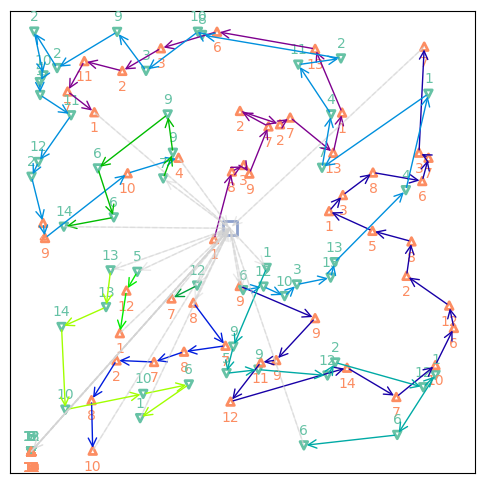

Cost:  13.57602310180664


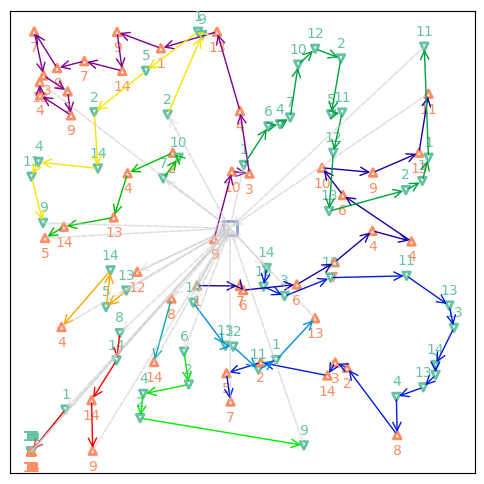

Cost:  12.86621379852295


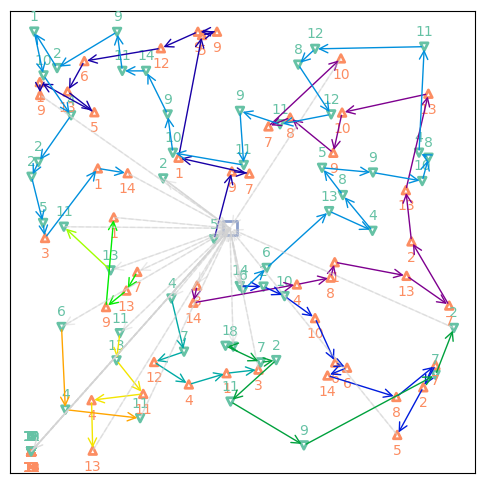

Cost:  14.494386672973633
tensor([[ 36,  80,  59,  57,  86,  78,  76,  27,  84,  81,  73,  23,  93,  30,
          67,  83,  31,   0,  40,  66,   7,  96,  61,   5,  15,  46,   4,  62,
          77,  88,  16,  37,  58,  97,  25,  70,  56,  13,   0,  63,  52,   2,
          55,  43,  20,   9,   0,  60, 100,  42,  99,  50,  39,  24,  91,  22,
          72,  28,  65,  47,  54,  53,  85,  69,  71,  49,  87,  17,  95,  44,
          75,  18,  68,   6,  92,   0,  38,  41,  14,   8,  90,  32,  94,  10,
          26,  74,   0,  89,  35,   0,  82,  51,  21,   3,  79,  98,   0,  19,
          33,  45,   0,  29,  64,  12,   1,  48,  34,  11,   0, 140, 115, 136,
         113, 125, 121, 143, 128, 114, 131, 124, 119, 118, 107, 134, 102, 141,
         112, 135, 108, 129, 139, 109, 116, 144, 111, 123,   0, 117, 110, 105,
         133, 120, 137, 126, 104, 103, 138, 130, 106, 142, 101, 122, 132, 127,
           0,   0,   0],
        [ 36,  80,  57,  78,  23,  93,  85,  30,  67,  69,  71,  49,  83,  95,
 

In [ ]:
actions = out['actions'].cpu().detach()
rewards = out['reward'].cpu().detach()
print(rewards)
# Plotting
for idx in range(batch_size[0]):
    env.render(td[idx], actions[idx])
    print("Cost: ", -rewards[idx].item())
    #print("Problem: ", variant_names[idx])
    #print(f"Tour lengths: {[f'{-r.item():.2f}' for r in rewards[idx]]}")
print(actions)
print(rewards)

# **METRICS**

In [ ]:
# Calculate the cost on the original scale
td['locs'] = repeat(coords, 'n d -> b n d', b=batch_size, d=2)
neg_reward = env.get_reward(td, out['actions'])
cost = ceil(-1 * neg_reward[0].item())

# Load the optimal cost
solution = vrplib.read_solution(os.path.join(path_to_save, instance+'.sol'))
optimal_cost = solution['cost']

# Calculate the gap and print
gap = (cost - optimal_cost) / optimal_cost
print(f'Problem: {instance:<15} Cost: {cost:<10} Optimal Cost: {optimal_cost:<10}\t Gap: {gap:.2%}')

EinopsError:  Error while processing repeat-reduction pattern "n d -> b n d".
 Input tensor shape: torch.Size([1, 145, 2]). Additional info: {'b': [3], 'd': 2}.
 Wrong shape: expected 2 dims. Received 3-dim tensor.